In [37]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor

In [1]:
ROUND = "226"
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"

In [3]:
# Load Data
training_data = pd.read_csv(f"../../dataset/numerai_dataset_{ROUND}/numerai_training_data.csv").set_index("id")
tournament_data = pd.read_csv(f"../../dataset/numerai_dataset_{ROUND}/numerai_tournament_data.csv").set_index("id")

In [4]:
# Sample submission file
sample_predict = pd.read_csv(f"../../dataset/numerai_dataset_{ROUND}/example_predictions_target_kazutsugi.csv").set_index("id")

In [12]:
training_data["era_no"] = training_data.era.str.slice(3).astype(int)

In [19]:
# MDIベースのeraクラスタリングから求めた後半データでtrain
training_data_ = training_data.query("era_no > 75")

---

In [15]:
# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)

In [38]:
# train xgb
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

print("Training model...")
# This is the model that generates the included example predictions file
# Taking too long? Set learning_rate=0.1 and n_estimators=200 to make this run faster
validation_data = tournament_data[tournament_data.data_type == "validation"].sample(10000)
X_val = validation_data[feature_names]
Y_val = validation_data[TARGET_NAME]
model = XGBRegressor(max_depth=5, learning_rate=0.005, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
model.fit(training_data_[feature_names], training_data_[TARGET_NAME], early_stopping_rounds=300, verbose=True, 
          eval_set=[(X_val, Y_val)])

# Generate predictions on both training and tournament data
print("Generating predictions...")
training_data_[PREDICTION_NAME] = model.predict(training_data_[feature_names])
tournament_data[PREDICTION_NAME] = model.predict(tournament_data[feature_names])

# Check the per-era correlations on the training set (in sample)
train_correlations = training_data_.groupby("era").apply(score)
print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")
print(f"On training the average per-era payout is {payout(train_correlations).mean()}")

# Check the per-era correlations on the validation set (out of sample)
validation_data = tournament_data[tournament_data.data_type == "validation"]
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")
print(f"On validation the average per-era payout is {payout(validation_correlations).mean()}")

Loaded 310 features
Training model...
[0]	validation_0-rmse:0.35274
Will train until validation_0-rmse hasn't improved in 300 rounds.
[1]	validation_0-rmse:0.35274
[2]	validation_0-rmse:0.35274
[3]	validation_0-rmse:0.35274
[4]	validation_0-rmse:0.35274
[5]	validation_0-rmse:0.35274
[6]	validation_0-rmse:0.35274
[7]	validation_0-rmse:0.35274
[8]	validation_0-rmse:0.35273
[9]	validation_0-rmse:0.35273
[10]	validation_0-rmse:0.35273
[11]	validation_0-rmse:0.35273
[12]	validation_0-rmse:0.35273
[13]	validation_0-rmse:0.35273
[14]	validation_0-rmse:0.35273
[15]	validation_0-rmse:0.35273
[16]	validation_0-rmse:0.35273
[17]	validation_0-rmse:0.35273
[18]	validation_0-rmse:0.35273
[19]	validation_0-rmse:0.35273
[20]	validation_0-rmse:0.35273
[21]	validation_0-rmse:0.35273
[22]	validation_0-rmse:0.35273
[23]	validation_0-rmse:0.35273
[24]	validation_0-rmse:0.35272
[25]	validation_0-rmse:0.35272
[26]	validation_0-rmse:0.35272
[27]	validation_0-rmse:0.35272
[28]	validation_0-rmse:0.35272
[29]	va

[257]	validation_0-rmse:0.35267
[258]	validation_0-rmse:0.35267
[259]	validation_0-rmse:0.35267
[260]	validation_0-rmse:0.35267
[261]	validation_0-rmse:0.35267
[262]	validation_0-rmse:0.35267
[263]	validation_0-rmse:0.35267
[264]	validation_0-rmse:0.35267
[265]	validation_0-rmse:0.35267
[266]	validation_0-rmse:0.35267
[267]	validation_0-rmse:0.35267
[268]	validation_0-rmse:0.35267
[269]	validation_0-rmse:0.35267
[270]	validation_0-rmse:0.35267
[271]	validation_0-rmse:0.35267
[272]	validation_0-rmse:0.35267
[273]	validation_0-rmse:0.35267
[274]	validation_0-rmse:0.35267
[275]	validation_0-rmse:0.35267
[276]	validation_0-rmse:0.35267
[277]	validation_0-rmse:0.35267
[278]	validation_0-rmse:0.35267
[279]	validation_0-rmse:0.35267
[280]	validation_0-rmse:0.35267
[281]	validation_0-rmse:0.35267
[282]	validation_0-rmse:0.35267
[283]	validation_0-rmse:0.35267
[284]	validation_0-rmse:0.35266
[285]	validation_0-rmse:0.35266
[286]	validation_0-rmse:0.35266
[287]	validation_0-rmse:0.35266
[288]	va

[514]	validation_0-rmse:0.35266
[515]	validation_0-rmse:0.35266
[516]	validation_0-rmse:0.35266
[517]	validation_0-rmse:0.35266
[518]	validation_0-rmse:0.35266
[519]	validation_0-rmse:0.35266
[520]	validation_0-rmse:0.35266
[521]	validation_0-rmse:0.35266
[522]	validation_0-rmse:0.35266
[523]	validation_0-rmse:0.35266
[524]	validation_0-rmse:0.35265
[525]	validation_0-rmse:0.35266
[526]	validation_0-rmse:0.35265
[527]	validation_0-rmse:0.35265
[528]	validation_0-rmse:0.35265
[529]	validation_0-rmse:0.35265
[530]	validation_0-rmse:0.35265
[531]	validation_0-rmse:0.35265
[532]	validation_0-rmse:0.35265
[533]	validation_0-rmse:0.35265
[534]	validation_0-rmse:0.35266
[535]	validation_0-rmse:0.35266
[536]	validation_0-rmse:0.35265
[537]	validation_0-rmse:0.35265
[538]	validation_0-rmse:0.35265
[539]	validation_0-rmse:0.35266
[540]	validation_0-rmse:0.35266
[541]	validation_0-rmse:0.35266
[542]	validation_0-rmse:0.35266
[543]	validation_0-rmse:0.35266
[544]	validation_0-rmse:0.35266
[545]	va

[771]	validation_0-rmse:0.35265
[772]	validation_0-rmse:0.35265
[773]	validation_0-rmse:0.35265
[774]	validation_0-rmse:0.35265
[775]	validation_0-rmse:0.35266
[776]	validation_0-rmse:0.35265
[777]	validation_0-rmse:0.35265
[778]	validation_0-rmse:0.35265
[779]	validation_0-rmse:0.35265
[780]	validation_0-rmse:0.35265
[781]	validation_0-rmse:0.35265
[782]	validation_0-rmse:0.35265
[783]	validation_0-rmse:0.35265
[784]	validation_0-rmse:0.35266
[785]	validation_0-rmse:0.35266
[786]	validation_0-rmse:0.35265
[787]	validation_0-rmse:0.35265
[788]	validation_0-rmse:0.35265
[789]	validation_0-rmse:0.35265
[790]	validation_0-rmse:0.35265
[791]	validation_0-rmse:0.35265
[792]	validation_0-rmse:0.35265
[793]	validation_0-rmse:0.35265
[794]	validation_0-rmse:0.35265
[795]	validation_0-rmse:0.35265
[796]	validation_0-rmse:0.35266
[797]	validation_0-rmse:0.35266
[798]	validation_0-rmse:0.35266
[799]	validation_0-rmse:0.35266
[800]	validation_0-rmse:0.35266
[801]	validation_0-rmse:0.35266
[802]	va

[1027]	validation_0-rmse:0.35266
[1028]	validation_0-rmse:0.35266
[1029]	validation_0-rmse:0.35266
[1030]	validation_0-rmse:0.35266
[1031]	validation_0-rmse:0.35266
[1032]	validation_0-rmse:0.35266
[1033]	validation_0-rmse:0.35266
[1034]	validation_0-rmse:0.35266
[1035]	validation_0-rmse:0.35267
[1036]	validation_0-rmse:0.35267
[1037]	validation_0-rmse:0.35266
[1038]	validation_0-rmse:0.35267
[1039]	validation_0-rmse:0.35267
[1040]	validation_0-rmse:0.35266
[1041]	validation_0-rmse:0.35267
[1042]	validation_0-rmse:0.35267
[1043]	validation_0-rmse:0.35266
[1044]	validation_0-rmse:0.35267
[1045]	validation_0-rmse:0.35266
[1046]	validation_0-rmse:0.35266
[1047]	validation_0-rmse:0.35266
[1048]	validation_0-rmse:0.35266
[1049]	validation_0-rmse:0.35266
[1050]	validation_0-rmse:0.35267
[1051]	validation_0-rmse:0.35267
[1052]	validation_0-rmse:0.35267
[1053]	validation_0-rmse:0.35266
[1054]	validation_0-rmse:0.35267
[1055]	validation_0-rmse:0.35267
[1056]	validation_0-rmse:0.35267
[1057]	val

/home/tarai/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


On training the correlation has mean 0.16542588126452484 and std 0.04023616490693029
On training the average per-era payout is 0.16542588126452484
On validation the correlation has mean 0.02317554929871474 and std 0.03427397906220715
On validation the average per-era payout is 0.02317554929871474


In [ ]:
tournament_data[PREDICTION_NAME].to_csv("tournament_xgb_pred.csv")
training_data_[PREDICTION_NAME].to_csv("training_xgb_pred.csv")

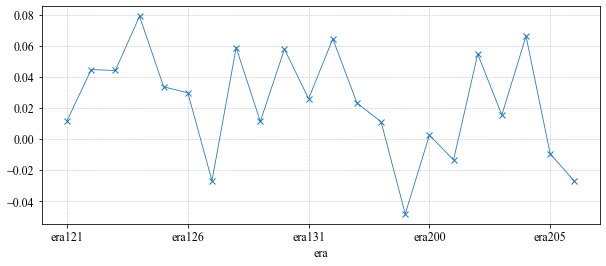

In [40]:
validation_correlations.plot(figsize=(10,4), marker="x");

In [41]:
# with open("model_xgb.pkl" , "wb") as f:
#     pickle.dump(model, f)